In [2]:
# visialize stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import json
# !pip install geopandas
import geopandas

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import random


import itertools

## Data visualization

- In this section, you are going to compute and visualize some information about Covid-19
- The data prepared in `./data` was collected from Worldometer
- Link: https://www.worldometers.info/coronavirus/

In [3]:
# read the data into a dataframe
df = pd.read_csv('./data/data.csv')
print(f'Shape: {df.shape}')
df.head(5)

Shape: (219, 10)


,Country Name,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Critical Cases,Total Tests,Population
0,USA,"31,990,143",NaN,"576,298",NaN,"24,560,856","6,852,989","9,321","420,822,699","332,516,170"
1,India,"13,689,453","+3,380","171,089",NaN,"12,253,697","1,264,667","8,944","259,207,108","1,390,568,032"
2,Brazil,"13,521,409",NaN,"355,031",NaN,"11,957,068","1,209,310","8,318","28,600,000","213,737,070"
3,France,"5,067,216",NaN,"99,135",NaN,"310,934","4,657,147","5,916","70,140,847","65,386,285"
4,Russia,"4,657,883","+8,173","103,601",338.0,"4,281,776","272,506","2,300","124,100,000","145,983,351"


### Requrement #1: Preprocess

- **TODO**: Take a look at the data files, then go to the URL aforementioned, explore the meaning of columns in the dataset and fill in the blanks:
    - Country Name: Name of that country
    - Total Cases: Total cases that infected with corona virus
    - New Cases: New Cases that infected with corona virus
    - Total Deaths: All deaths cases 'cause of corona virus
    - New Deaths: Number of new deaths cases
    - Total Recovered: All people that have recovered from corona virus
    - Active Cases: Refers to the number of people currently infected with the disease and still undergoing treatment
    - Critical Cases: Refers to the number of patients who are in severe condition, requiring special medical care
    - Total Tests: Refers to the total number of tests performed on a national scale
    - Population: Population of the country that had mentioned before

- Check the data with `info()` function

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    object 
 2   New Cases        46 non-null     object 
 3   Total Deaths     219 non-null    object 
 4   New Deaths       32 non-null     float64
 5   Total Recovered  217 non-null    object 
 6   Active Cases     217 non-null    object 
 7   Critical Cases   146 non-null    object 
 8   Total Tests      210 non-null    object 
 9   Population       219 non-null    object 
dtypes: float64(1), object(9)
memory usage: 17.2+ KB


- You can see that `New Cases`, `New Deaths`, `Critical Cases` have a lot of missing data (at least 33.3%). Therefore, we have to remove these columns.
- Most of data in columns are `object` type, which are not suitable at all. They should be converted to integer.
- `Total Recovered`, `Active Cases` and `Total Tests` only have a few missing values, so we can fill in these missing values with median value of each column.

In [5]:
# TODO: drop New Cases, New Deaths, Critical Cases
df =df.drop(columns='New Cases', axis=1)
df =df.drop(columns='New Deaths', axis=1)
df =df.drop(columns='Critical Cases', axis=1)

# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     219 non-null    object
 1   Total Cases      219 non-null    object
 2   Total Deaths     219 non-null    object
 3   Total Recovered  217 non-null    object
 4   Active Cases     217 non-null    object
 5   Total Tests      210 non-null    object
 6   Population       219 non-null    object
dtypes: object(7)
memory usage: 12.1+ KB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     219 non-null    object
 1   Total Cases      219 non-null    object
 2   Total Deaths     219 non-null    object
 3   Total Recovered  217 non-null    object
 4   Active Cases     217 non-null    object
 5   Total Tests      210 non-null    object
 6   Population       219 non-null    object
dtypes: object(7)
memory usage: 12.1+ KB


In [7]:
# TODO: convert data to integer. if the converter returns error, leave it a None
convert = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases', 'Total Tests', 'Population']
for col in convert:
    df[col] = df[col].str.replace(',', '').str.replace(' ', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int64  
 2   Total Deaths     204 non-null    float64
 3   Total Recovered  217 non-null    float64
 4   Active Cases     217 non-null    float64
 5   Total Tests      210 non-null    float64
 6   Population       219 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 12.1+ KB


**TODO**: We did handle missing value before. Why do we still have missing values here?

Well, there's some special characters appear in collumns (e.g: ' ' ,''), that makes pandas misunderstand and it assumes these characters are the the real data, after we only convert the data to numeric type, this misunderstand is fixed.

In [8]:
# TODO: fill in the missing data with median value
numeric_cols = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases', 'Total Tests', 'Population']
for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int64  
 2   Total Deaths     219 non-null    float64
 3   Total Recovered  219 non-null    float64
 4   Active Cases     219 non-null    float64
 5   Total Tests      219 non-null    float64
 6   Population       219 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 12.1+ KB


**TODO**: Why do we have `float64` here?

In the 2nd backwards column, we convert the object type in to integer type. It causes a small change here, the NaN is a special floating point value in Python. So yeah, we have float64 <3

In [9]:
# TODO: save your new data frame to `./data/new_data.csv`
df.to_csv('data/new_data.csv', index=False)

In [10]:
# TEST
file = open('./data/new_data.csv', 'r')
new_data = file.read()
file.close()

file = open('./data/correct_data.csv', 'r')
correct_data = file.read()
file.close()

assert new_data == correct_data

### Requirement #2: Visualize single variable

- For now, if you do not pass the test, you have to work on the correct file by un-commenting the cell code below to read the `./data/correct_data.csv` into `df`
- You are going to draw 6 bar charts which show all the fields of dataset. For each bar chart, sort the values of countries in descending order and only visualize 5 countries

In [11]:
# # un-comment these lines of code
# df = pd.read_csv('./data/correct_data.csv')

df.head()

,Country Name,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Tests,Population
0,USA,31990143,576298.0,24560856.0,6852989.0,420822699.0,332516170
1,India,13689453,171089.0,12253697.0,1264667.0,259207108.0,1390568032
2,Brazil,13521409,355031.0,11957068.0,1209310.0,28600000.0,213737070
3,France,5067216,99135.0,310934.0,4657147.0,70140847.0,65386285
4,Russia,4657883,103601.0,4281776.0,272506.0,124100000.0,145983351


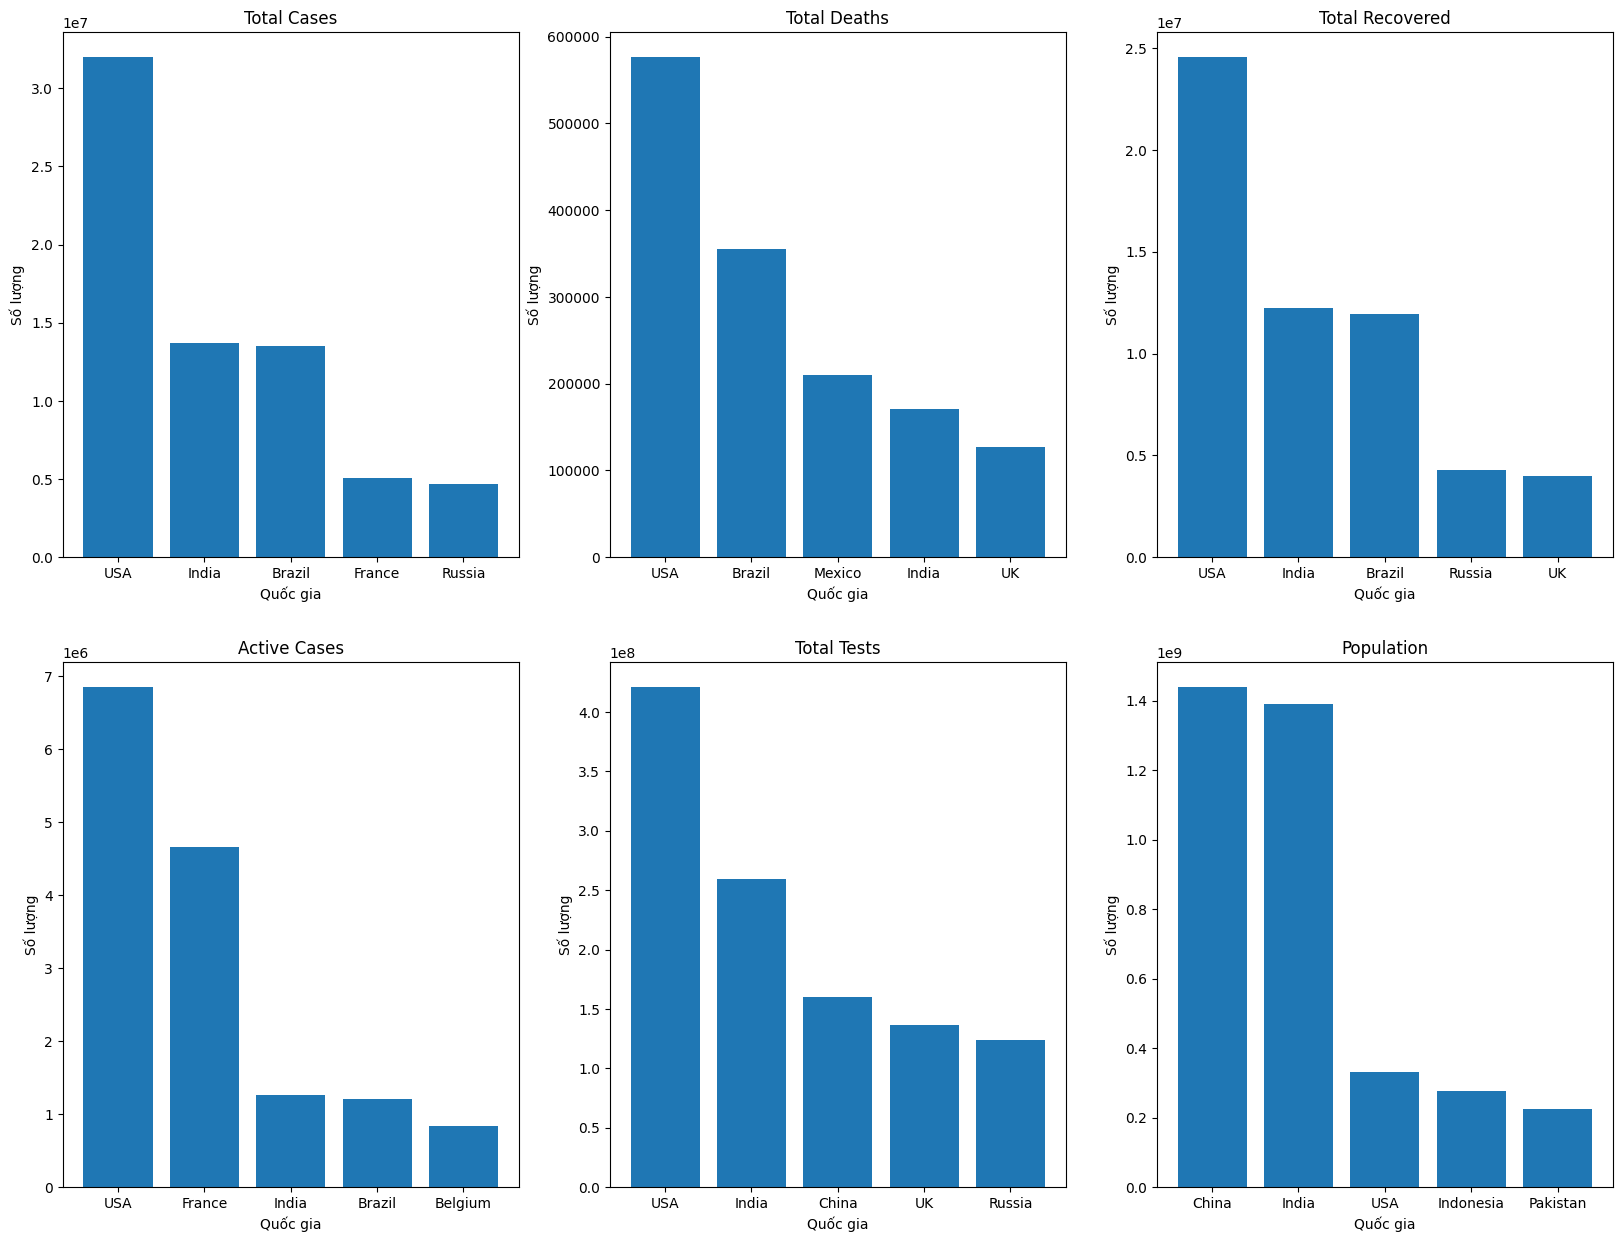

In [12]:
# TODO: draw 6 bar charts

cols = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases', 'Total Tests', 'Population']
fig, axs = plt.subplots(2, 3, figsize=(20, 15))

for i, col in enumerate(cols):
    ax = axs[i // 3, i % 3]
    sorted_df = df.sort_values(by=col, ascending=False).head()  # Lấy 5 giá trị cuối cùng
    ax.bar(sorted_df['Country Name'], sorted_df[col])
    ax.set_title(col)
    ax.set_xlabel('Quốc gia') 
    ax.set_ylabel('Số lượng')   

plt.show()

**TODO**: Comment about the chart

These charts help us to compare COVID-19 numbers between different countries. We can easily compare COVID-19 cases, deaths, or other attributes across countries.

### Requirement #3: Draw world map

- Using bar chart just gives you a little bit information about numbers
- In this requirement, you are going to draw a world map with circles which shows the number of cases for each country. Specifically, you are provided a file named `coord.json` that contains longitude and latitude of each country. You are going to use `Total cases` and `Total Death` to draw the following charts

C:\Users\FPTSHOP\AppData\Local\Temp\ipykernel_14892\214091523.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


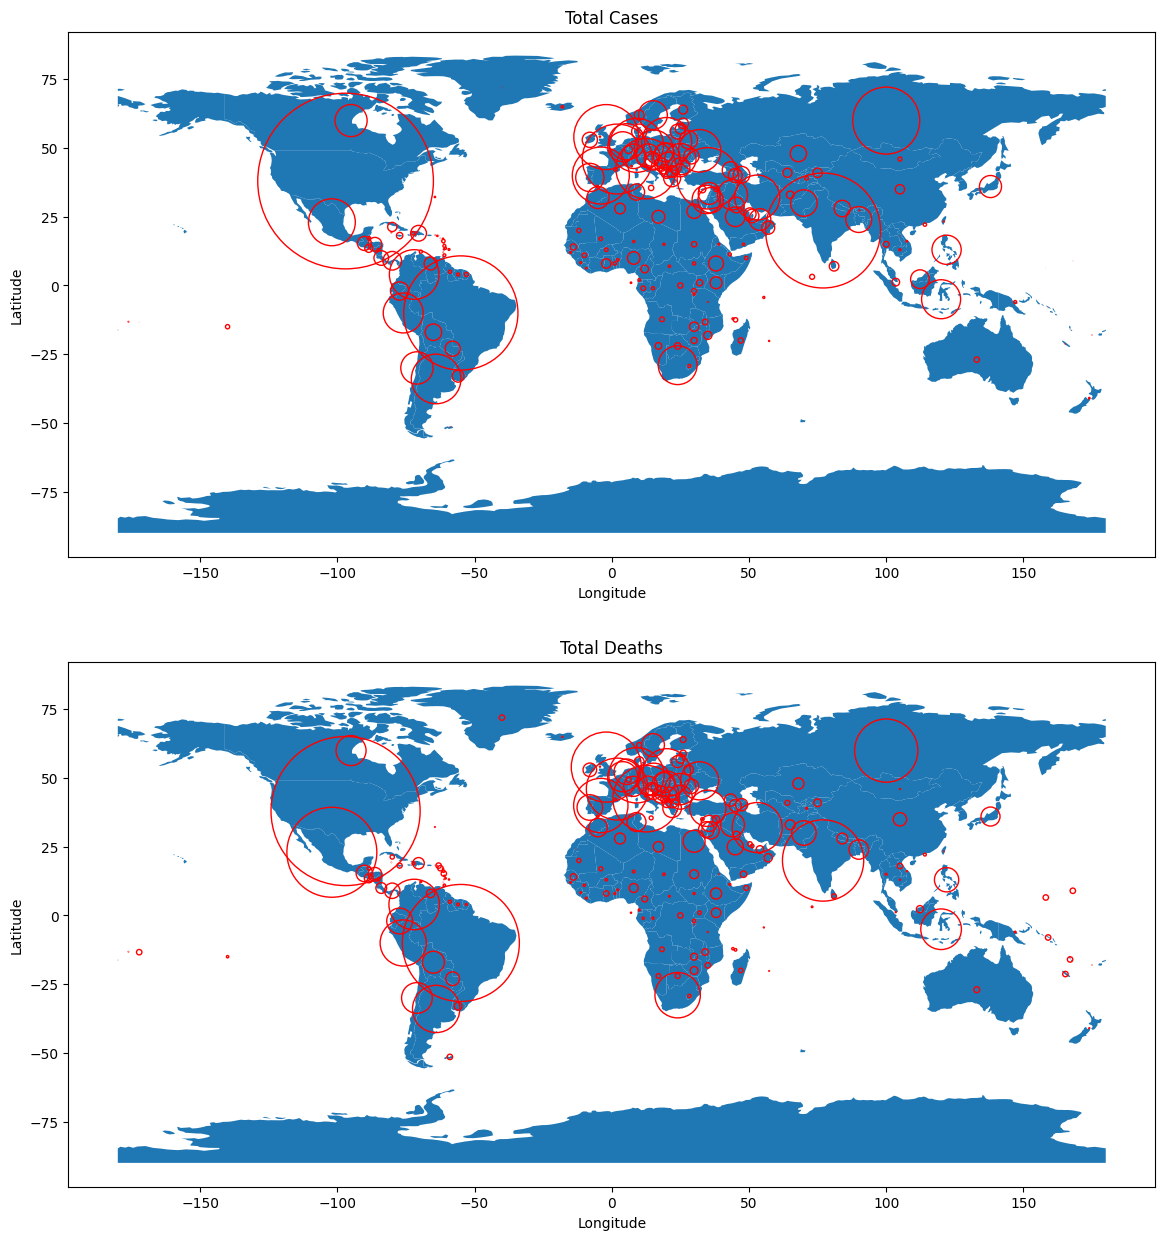

In [13]:
# TODO: draw 2 world map chart using geopandas
with open('data/coord.json', 'r') as file:
    data = json.load(file)

df_coord = geopandas.GeoDataFrame.from_dict(data)
df_coord['Country Name'] = df_coord.index

df_coord.reset_index(drop=True, inplace=True)
merged_data = pd.merge(df_coord, df, on='Country Name')


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))


world.plot(ax=ax1)
ax1.scatter(merged_data['long'], merged_data['lat'], s=merged_data['Total Cases']/2000, edgecolor='red', facecolor='none', alpha=1)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Total Cases')


world.plot(ax=ax2)
ax2.scatter(merged_data['long'], merged_data['lat'], s=merged_data['Total Deaths']/50, edgecolor='red', facecolor='none', alpha=1)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Total Deaths')

plt.show()

**TODO**: Comment about the chart

The number of cases of infection and the number of deaths distributed mainly in the US, Europe, India and South America.
Although Africa has a small number of cases and the number of deaths, most countries have cases of infection and death.

### Requirement #4: Relationship between 2 variables

- Exploring the relationship between variables is a needed task to do
- You will start with exploring the linear relationship between 2 variables. In order to do so, draw $C_6^2=15$ scatter plots. For each plot, draw a line that shows the linear relationship of variables. You should implement the line yourself instead of using library.

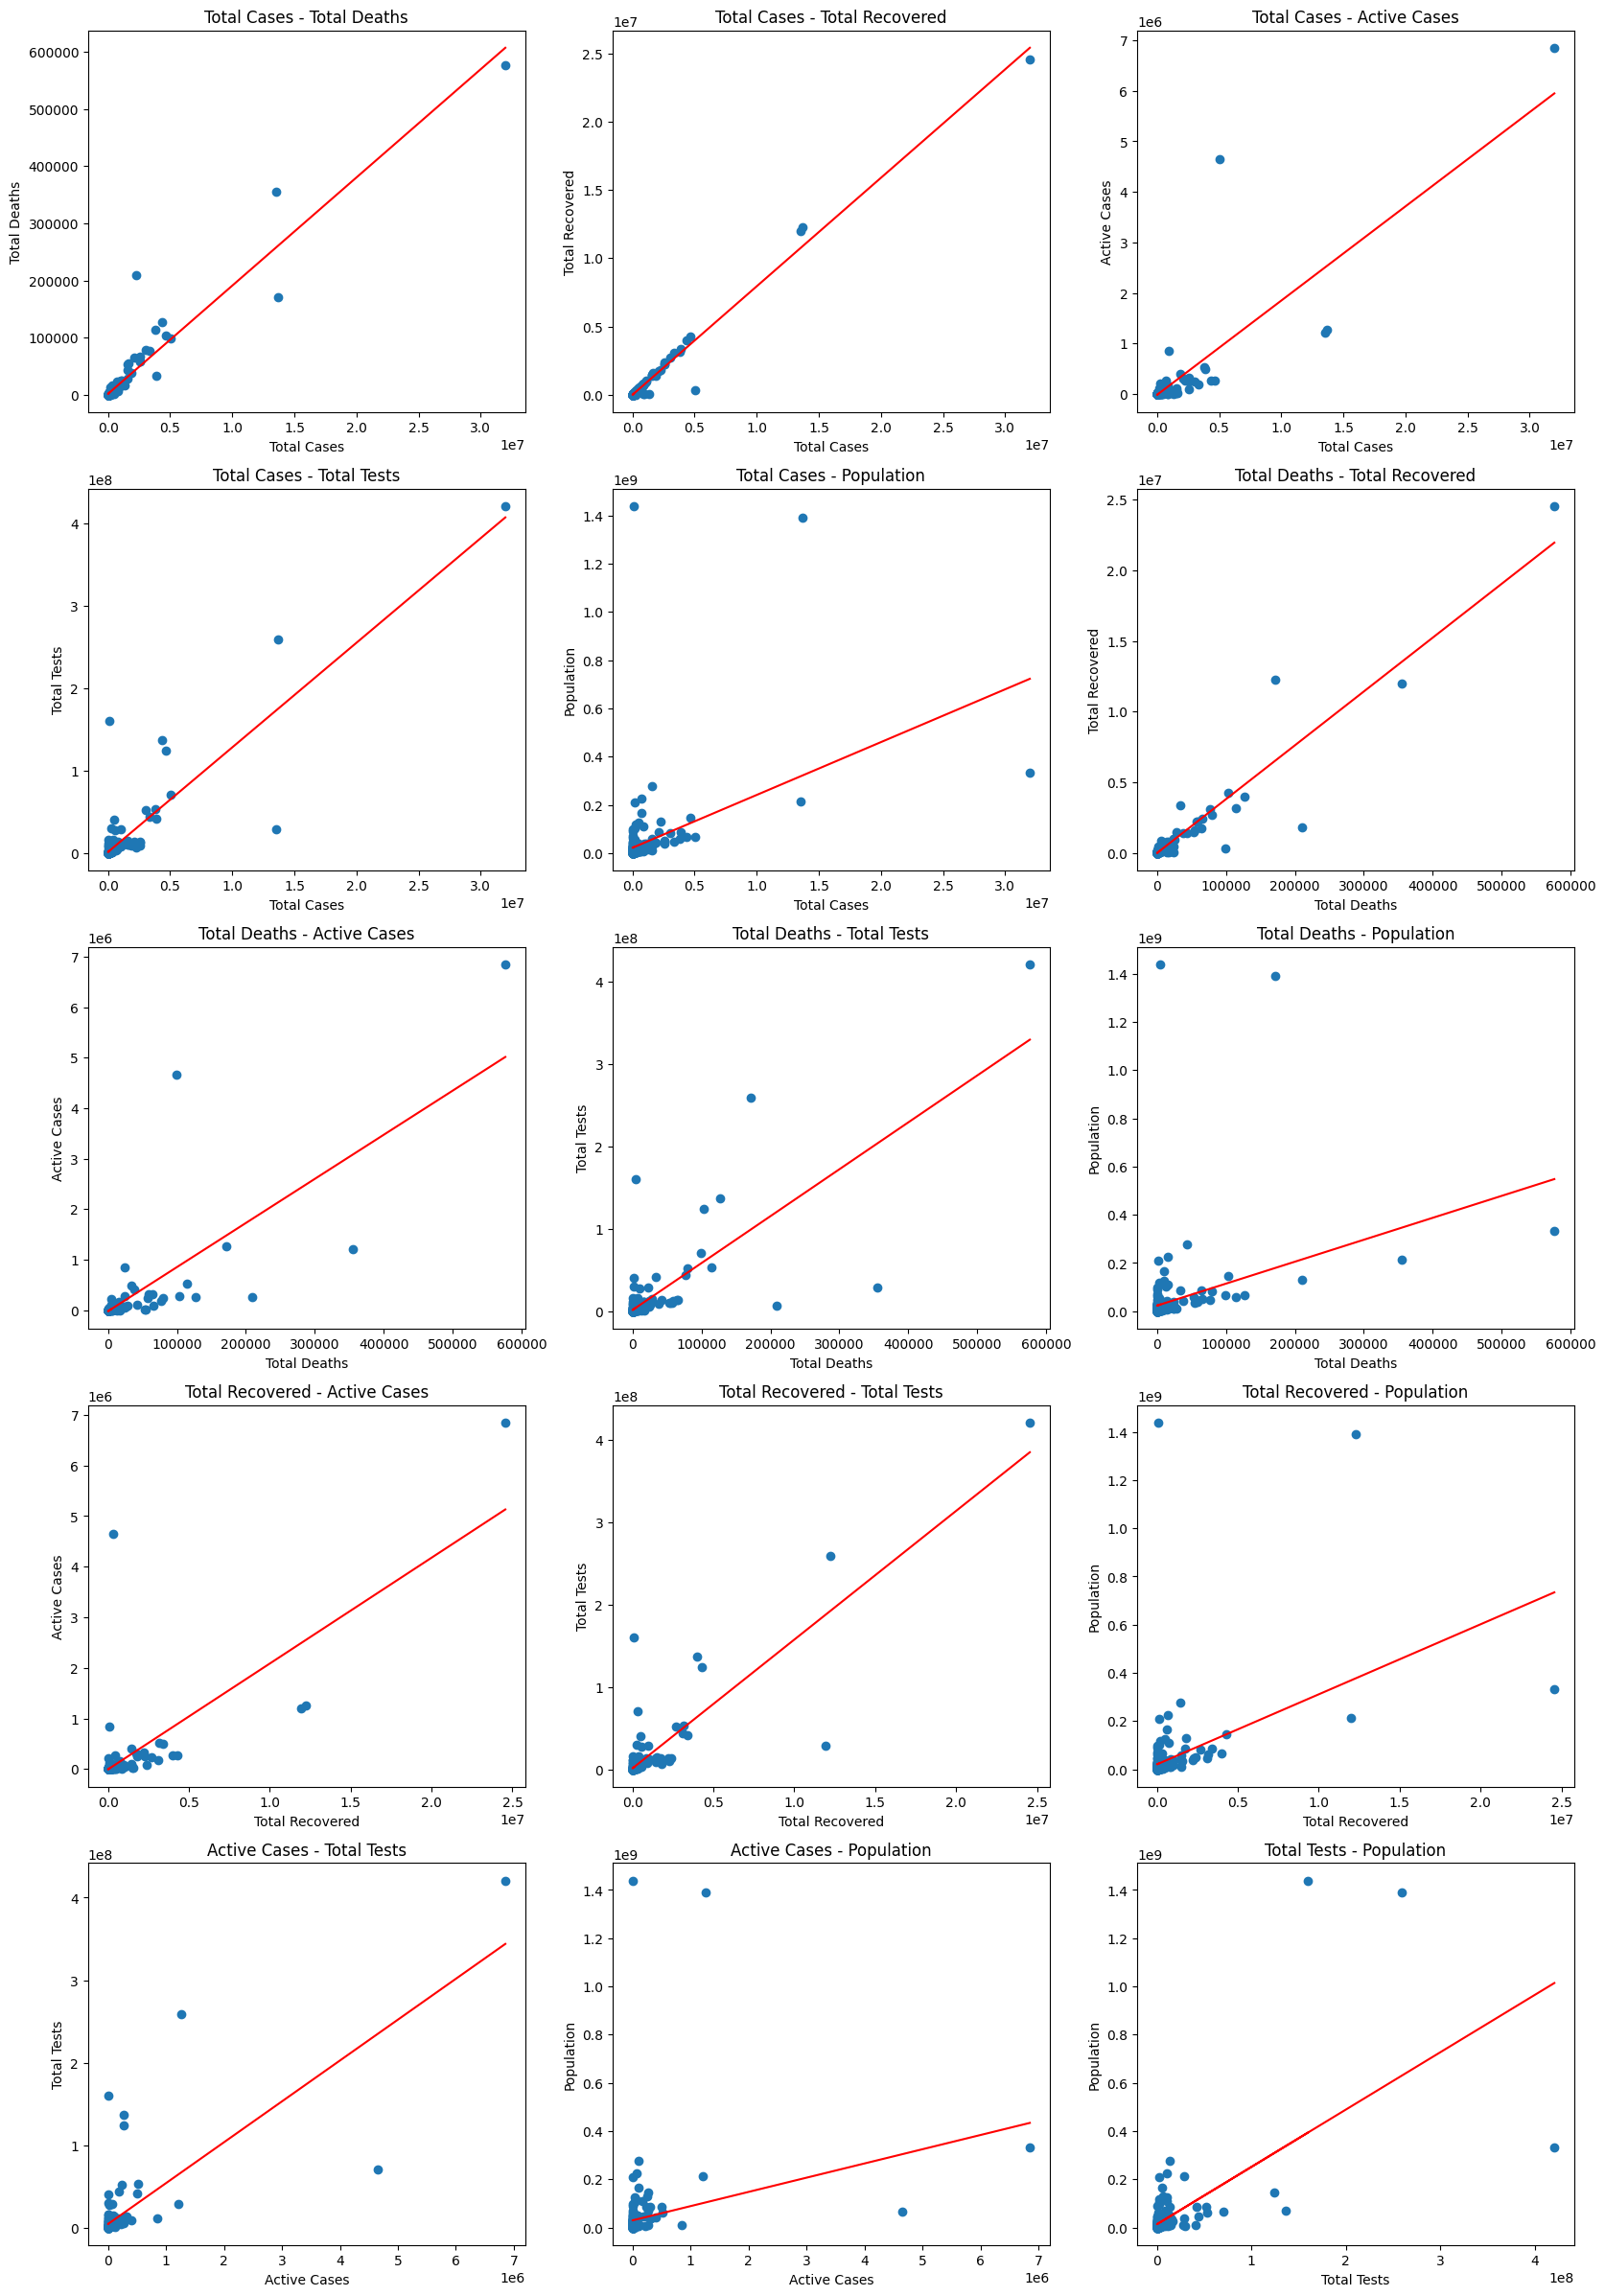

In [14]:
# TODO: scatter stuff
attributes =df.columns[1:]  

plt.figure(figsize=(20, 30))
num = 1
for combination in itertools.combinations(attributes, 2):
    attributes_1, attributes_2 = combination
    plt.subplot(5, 3, num)
    plt.scatter(df[attributes_1], df[attributes_2])
    plt.xlabel(attributes_1)
    plt.ylabel(attributes_2)
    plt.title(f"{attributes_1} - {attributes_2}")
    
    #vẽ
    x = df[attributes_1]
    y = df[attributes_2]

    coefficients = np.polyfit(x,y,1)
    linear_equation = np.poly1d(coefficients)
    plt.plot(x, linear_equation(x),color='red')

    num += 1


plt.show()

**TODO**: As showed above, give your prediction about the relationship between each pair.

**Because these graphs have quite similar shapes, I would like to give general comments instead of detailed comments for each graph of each pair of data:**
The correlation between pairs of attributes is quite high, meaning that if one attribute increases, the other attribute also increases.

### Requirement #5: Double check the relationship between 2 variables

- In order to make sure about the linear relationship, you have to check each pair with **Pearson correlation coefficient**
- Specifically, $\rho$ is calculated as follows:

$$\rho_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

- Then, plot these 15 values using heatmap

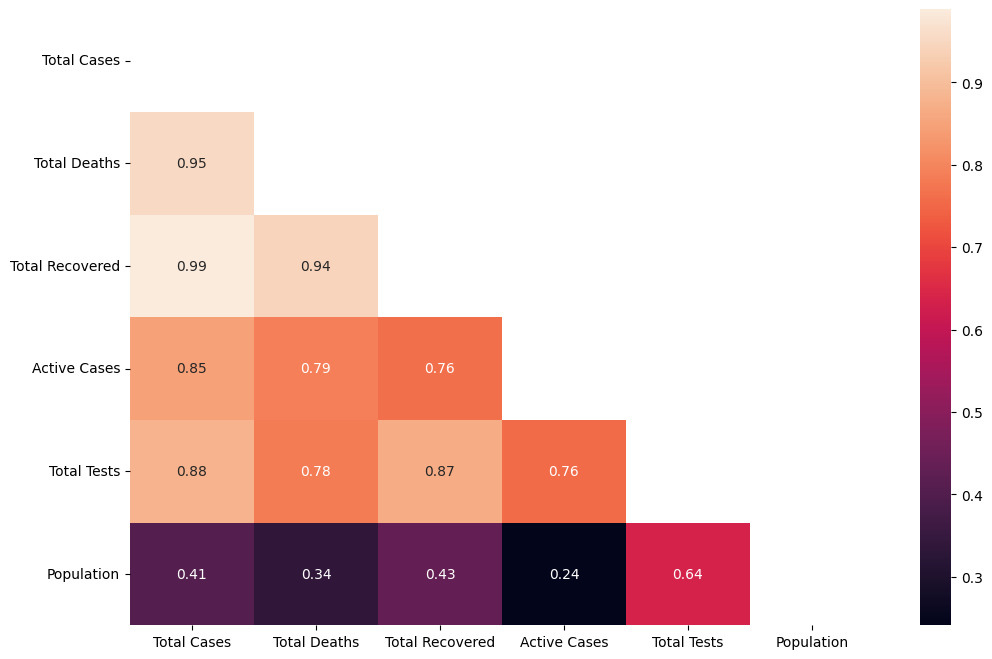

In [15]:
# TODO: create heatamp
attributes = df.columns[1:]

mask = np.triu(np.ones_like(df[attributes].corr(), dtype=bool))
plt.figure(figsize=(12, 8))
sn.heatmap(df[attributes].corr(), annot=True, mask=mask)
plt.yticks(rotation=0)
plt.show()

For now, you can check whether your prediction is right or wrong!

## Model visualization

- In this section, we are going to visualize the training and testing process of machine learning model
- The process of training and testing a model is as follow:
    1. Prepare data for training and testing
    2. Create a model
    3. Train and test the model
    4. Visualize the result

- You are required to:
    1. Study Multi-layer neural network and Convolutional neural network
    2. Study `Pytorch` in order to prepare data and design machine learning model
    3. Design 2 models to classify MNIST dataset. Then, visualize the result of each model and compare the result to each other
        - Model 1: A fully-connected model with 4 layers. The input layer has $784$ neurons. The hidden layer #1 has $1024$ neurons, which is followed by a $ReLU$ as activation functions. The hidden layer #2 has $512$ neurons, also followed by a $ReLU$ as activation functions. The output layer has $10$ neurons (of course), which follows by a $LogSoftmax$ function
        - Model 2: A CNN model with 2 Convolution layers and 1 linear layer. All the CNN layers have 20 filters, kernel size equal to $5$. Each of them is followed by a $ReLU$ activation function and a MaxPooling2D layer ($kernel\_size=2$). The linear layer is followed by a $LogSoftmax$ activation function

- Google Colab can be used since it provides free GPU, which makes your training and testing process faster

### Requirement #6: Prepare data

- `Pytorch` supports a lot of datasets for running machine learning model. In this lab, we use MNIST dataset. So, download the training set and the testing set using `Pytorch` and store them in `./data`
- Note that you have to transform your data into `tensor` (a datatype that's quite similar to `numpy array`) so you can input to model
- After that, create `train_dataloader` and `test_dataloader`

**TODO**: Explain why we have to create dataloader

There's some reasons for this: 
- Create batches: DataLoader allows dividing data into batches of a certain size. Using batches in the training process helps speed up the calculation process and supports model optimization.
- Shuffling data: During training, mixing data helps the model learn more generally.
- DataLoader helps manage data, optimizes computational performance, and provides a flexible mechanism for iterating training on training data.

In [19]:
# TODO: download training, testing data and store them into training_data and testing_data
# Then, create train_dataloader and test_dataloader with batch_size=32
data_transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




33.8%

100.0%
100.0%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



- After downloading the data, visualize 10 random samples (2 rows, 5 samples for each row) from training set.

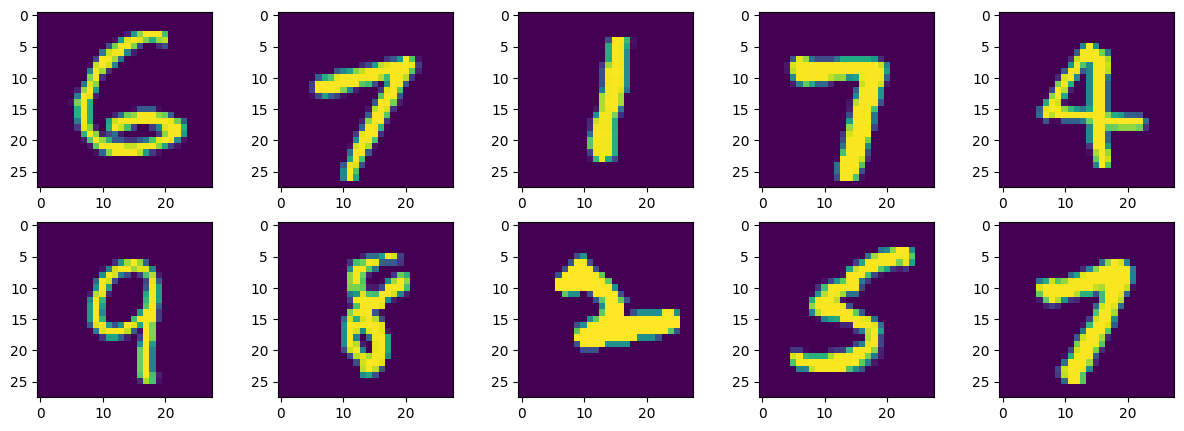

In [35]:
# TODO: visualize 10 random samples
random = np.random.randint(0, len(train_set), size=10)
samples = [train_set[i] for i in random]

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, (image, label) in enumerate(samples):
    ax = axs[i//5, i%5]
    ax.imshow(image.squeeze())

plt.show()

In [39]:
test_set.data.shape

torch.Size([10000, 28, 28])

### Requirement #7: Create models

- Create 2 models as mentioned above. Call them `Mnist_FC` and `Mnist_CNN`
- **I strongly recommend that you should slowly implement, print out the output and its shape of each layer in order to get a deep understanding of what you are trying to do**
- Before moving to the next requirement, you should test your model with a random sample of the dataset. In case you create code cells for testing, remember to remove these cells

In [40]:
# TODO: create Mnist_FC and Mnist_CNN
class Mnist_FC(nn.Module):
    def __init__(self):
        super(Mnist_FC, self).__init__()
        self.linear_1 = nn.Linear(784, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 10)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.logsoftmax(x)
        return x


class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.linear = nn.Linear(20 * 4 * 4, 10)
        
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 20 * 4 * 4)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x


**Reference Idea Source:** https://www.youtube.com/watch?v=QML-jlpsaOU&t=467s

### Requirement #8: Train and test models

- Design `train` and `test` function with the parameters provided in the following code cell
    - `train` function trains the model with all the data in training set
    - `test` function tests the model with all data in testing set

- Return the accuracy (e.g. $0.847351$) after training and testing

**TODO**: Explain the parameters of `train` and `test` function. In `test` function, there is a line of code that says `with torch.no_grad()`. Why do we have this line of code?

- **Explain parameters:**
    - dataloader : the batch that we split before.
    - model: the model that we had built above.
    - loss_fn: a function used to measure the difference between a model's prediction and the actual value.
    - optimizer: is an algorithm that determines how to update the weights of the neural network or the parameters of the prediction model to minimize the loss function during training.
- **Explain this line of code: with torch.no_grad():** Used during the validation or testing process of the model. During validation or testing, we do not need gradients and do not need to update model weights. Therefore, disabling gradient calculation saves computational and memory resources.

In [61]:
# TODO: design train and test function

# check gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} for training and testing')

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for i, (image, targets) in enumerate(dataloader):
        optimizer.zero_grad()

        if isinstance(model, Mnist_FC):
            image = image.view(image.size(0), -1)       
        predict = model(image)

        loss = loss_fn(predict, targets)
        train_loss += loss.item()

        _, predicted = predict.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()
    avg_loss = train_loss / len(dataloader.dataset)
    accuracy = correct / total

    return accuracy
    

def test(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            image, targets = data
            if isinstance(model, Mnist_FC):
                image = image.view(image.size(0), -1)
            outputs = model(image)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = correct / total 
    return accuracy

Using cpu for training and testing


- Run 20 epochs for each model. In order to do so, at fist, you have to define `learning_rate, loss_fn` and `optimizer`. I will help you on that

- Save the history of training and testing process as `history_fc` and `history_cnn`. During the running process, you should print out the accuracy in order to keep track

- The history is a dictionary with the following structure:

```python
history = {
    1: [0.6, 0.5], # the key (type: int) is the epoch
    2: [0.7, 0.6], # the value (type: list) contains the accuracy of training and testing process at the corresponding epoch
    ...
}
```

**TODO**: List out some loss functions and optimizers that you have heard about
- **Loss Functions:**
    - Cross-Entropy Loss: Used mainly for classification problems. This is a combined function between Softmax and Negative Log Likelihood.
    - Mean Squared Error Loss: Used mainly for regression problems. It calculates the mean squared error between the predicted value and the actual value, i had mentioned and had used it lab02.
- **Optimizers:**
    - Stochastic Gradient Descent (being used in this lab): Classical optimization algorithm, updates weights based on the gradient of the entire data.
    - Adam: i encountered this algorithm when i was watching the video that i mentioned in the reference source, Combines both the ideas of RMSProp and Momentum. It generally performs well on many types of problems and has a fast convergence rate. I haven't learnt about this algorithm that much, so my current knowledge 'bout this just limited in knowing this algorithm.

In [72]:
model_fc = Mnist_FC()
model_cnn = Mnist_CNN()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer_fc = torch.optim.SGD(model_fc.parameters(), lr=learning_rate)
optimizer_cnn = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
# TODO: run 20 epochs for Mnist_FC and Mnist_CNN

history_fc = {}
history_cnn = {}

for epoch in range(1, 21):
    train_accuracy_cnn = train(train_dataloader, model_cnn, loss_fn, optimizer_cnn)
    test_accuracy_cnn = test(test_dataloader, model_cnn)
    history_cnn[epoch] = [train_accuracy_cnn, test_accuracy_cnn]
    print(f'Epoch {epoch}: Train accuracy - {train_accuracy_cnn:.5f}, Test accuracy - {test_accuracy_cnn:.5f}')

Epoch 1: Train accuracy - 0.31448, Test accuracy - 0.62680
Epoch 2: Train accuracy - 0.71548, Test accuracy - 0.81040
Epoch 3: Train accuracy - 0.82518, Test accuracy - 0.85970
Epoch 4: Train accuracy - 0.86383, Test accuracy - 0.87920
Epoch 5: Train accuracy - 0.88083, Test accuracy - 0.89240
Epoch 6: Train accuracy - 0.89145, Test accuracy - 0.90180
Epoch 7: Train accuracy - 0.89863, Test accuracy - 0.90860
Epoch 8: Train accuracy - 0.90505, Test accuracy - 0.91330
Epoch 9: Train accuracy - 0.91107, Test accuracy - 0.92010
Epoch 10: Train accuracy - 0.91532, Test accuracy - 0.92380
Epoch 11: Train accuracy - 0.91967, Test accuracy - 0.92810
Epoch 12: Train accuracy - 0.92430, Test accuracy - 0.93250
Epoch 13: Train accuracy - 0.92757, Test accuracy - 0.93580
Epoch 14: Train accuracy - 0.93090, Test accuracy - 0.93910
Epoch 15: Train accuracy - 0.93415, Test accuracy - 0.94050
Epoch 16: Train accuracy - 0.93693, Test accuracy - 0.94450
Epoch 17: Train accuracy - 0.93973, Test accuracy

In [74]:
for epoch in range(1, 21):
    train_accuracy_fc = train(train_dataloader, model_fc, loss_fn, optimizer_fc)
    test_accuracy_fc = test(test_dataloader, model_fc)
    history_fc[epoch] = [train_accuracy_fc, test_accuracy_fc]
    print(f'Epoch {epoch}: Train accuracy - {train_accuracy_fc:.5f}, Test accuracy - {test_accuracy_fc:.5f}')

Epoch 1: Train accuracy - 0.24938, Test accuracy - 0.38460
Epoch 2: Train accuracy - 0.49888, Test accuracy - 0.61480
Epoch 3: Train accuracy - 0.65317, Test accuracy - 0.69460
Epoch 4: Train accuracy - 0.70150, Test accuracy - 0.72110
Epoch 5: Train accuracy - 0.72352, Test accuracy - 0.74460
Epoch 6: Train accuracy - 0.75465, Test accuracy - 0.78140
Epoch 7: Train accuracy - 0.78892, Test accuracy - 0.80850
Epoch 8: Train accuracy - 0.81288, Test accuracy - 0.82670
Epoch 9: Train accuracy - 0.82810, Test accuracy - 0.83860
Epoch 10: Train accuracy - 0.84008, Test accuracy - 0.84860
Epoch 11: Train accuracy - 0.85008, Test accuracy - 0.85900
Epoch 12: Train accuracy - 0.85847, Test accuracy - 0.86860
Epoch 13: Train accuracy - 0.86530, Test accuracy - 0.87360
Epoch 14: Train accuracy - 0.87137, Test accuracy - 0.87880
Epoch 15: Train accuracy - 0.87612, Test accuracy - 0.88390
Epoch 16: Train accuracy - 0.88035, Test accuracy - 0.88740
Epoch 17: Train accuracy - 0.88403, Test accuracy

### Requirement #9: Visualize

- Produce a graph as the following code cell and comment about the running process of 2 models

**TODO**: Your comment

...

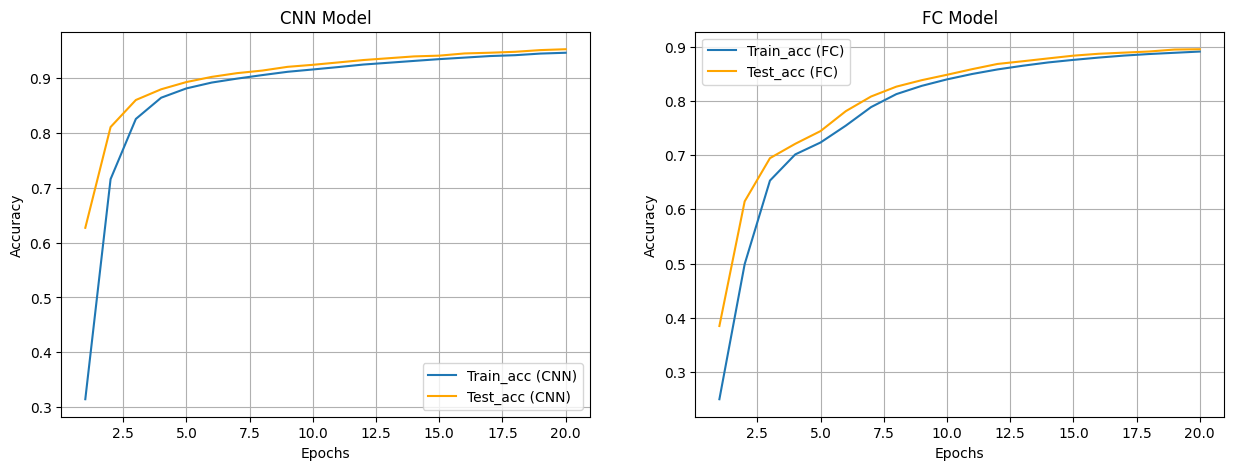

In [75]:
# TODO: visualize the history
epochs = list(history_fc.keys())
train_acc_fc = [value[0] for value in history_fc.values()]
test_acc_fc = [value[1] for value in history_fc.values()]

train_acc_cnn = [value[0] for value in history_cnn.values()]
test_acc_cnn = [value[1] for value in history_cnn.values()]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_cnn, label='Train_acc (CNN)')
plt.plot(epochs, test_acc_cnn, label='Test_acc (CNN)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_fc, label='Train_acc (FC)')
plt.plot(epochs, test_acc_fc, label='Test_acc (FC)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FC Model')
plt.legend()
plt.grid(True)

plt.show()

- Highly recommend you go play around with the parameters of models and re-implement 2 models using `TensorFlow` on Colab